In this notebook two deep learning methods are tested for air pollution prediction. **LSTM** and **CNN**. 

Univariate and Multivariate models are created to compare how a larger number of features affects the accuracy of the forecasts.


In the univariate models only values from previous days are used to make a prediction, whereas, in the multivariate models, weather forecast features are also taken in account for the prediction.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import log
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Flatten
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras import optimizers
from matplotlib import pyplot

import warnings
warnings.filterwarnings("ignore")

In [2]:
def split_ts_by_window(time_series, n_steps):
    window, output = list(), list()
    
    #UNIVARIATE MODEL
    if(isinstance(time_series, pd.Series)):
        for i in range(len(time_series)):
        
            #'n_steps' IS THE NUMBER OF PREVIOUS OBSERVATIONS I USED TO PREDICT THE NEXT VALUE
            #CREATE A WINDOW OF 'n_steps'
            window_limit = i + n_steps

            #IF THE END OF THE TIME SERIES IS REACHED BREAK THE LOOP
            if window_limit > len(time_series)-1:
                break

            #STORE EACH SEQUENCE OF 'n_steps' OBSERVATIONS TO THE 'window' LIST, WHICH IS GOING TO BE THE MODEL INPUT
            #AND STORE THE OUTPUT VALUE WHICH IS THE OBSERVATION AFTER THE END OF THE WINDOW
            input_features, output_pollutant = time_series[i:window_limit], time_series[window_limit]

            window.append(input_features)
            output.append(output_pollutant)
    
    #MULTIVARIATE MODEL
    else:
        for i in range(len(time_series)):
        
            #'n_steps' IS THE NUMBER OF PREVIOUS OBSERVATIONS I USED TO PREDICT THE NEXT VALUE
            #CREATE A WINDOW OF 'n_steps'
            window_limit = i + n_steps

            #IF THE END OF THE TIME SERIES IS REACHED BREAK THE LOOP
            if window_limit > len(time_series):
                break

            #STORE EACH SEQUENCE OF 'n_steps' OBSERVATIONS TO THE 'window' LIST, WHICH IS GOING TO BE THE MODEL INPUT
            #AND STORE THE OUTPUT VALUE COMING FROM 'n_steps' WINDOW USED

            #THE OUTPUT VALUES ARE THOSE OF THE FIRST COLUMN (POLLUTANT COLLUMN)
            input_features, output_pollutant = time_series[i:window_limit,:], time_series[window_limit-1,0]
            
            window.append(input_features)
            output.append(output_pollutant)
        
    return np.asarray(window).astype('float32'), np.asarray(output).astype('float32')

In [3]:
#GATHER ATHENS DATA FROM ALL AVAILABLE YEARS
Athens_Data = pd.read_csv('Athens_data.csv', index_col=0)

In [4]:
#ATHENS DATA PREVIEW
Athens_Data

,no2,o3,pm10,pm25,so2,temp,dew,humidity,windspeed,winddir
2019-11-07,0.576208,0.470135,0.721311,0.352381,0.000000,0.609467,0.872659,0.692094,0.331906,0.424969
2019-11-08,0.423792,0.470135,0.442623,0.352381,0.039683,0.576923,0.812734,0.647712,0.304069,0.291096
2019-11-09,0.442379,0.454721,0.213115,0.228571,0.039683,0.494083,0.715356,0.664910,0.233405,0.352117
2019-11-10,0.237918,0.516378,0.131148,0.152381,0.039683,0.523669,0.812734,0.758669,0.293362,0.590598
2019-11-11,0.356877,0.375723,0.229508,0.180952,0.039683,0.491124,0.760300,0.740499,0.051392,0.469801
...,...,...,...,...,...,...,...,...,...,...
2022-03-15,0.371747,0.539499,0.327869,0.419048,0.277778,0.213018,0.235955,0.441054,0.334047,0.640722
2022-03-16,0.442379,0.547206,0.426230,0.542857,0.317460,0.230769,0.385768,0.640777,0.331906,0.464508
2022-03-17,0.338290,0.587669,0.459016,0.504762,0.198413,0.310651,0.464419,0.618585,0.453961,0.342777
2022-03-18,0.204461,0.633911,0.295082,0.342857,0.079365,0.198225,0.217228,0.424411,0.588865,0.179016


## Data Preparation for Univariate Models

In [5]:
#DATA PREPARATION FOR UNIVARIATE MODELS

#KEEP ONLY THE POLLUTANTS COLUMNS
cols=['pm25', 'pm10', 'no2', 'o3', 'so2']

#MAKE VALUES NUMERIC
Athens_Data_uni = Athens_Data.loc[:, Athens_Data.columns.intersection(cols)]
Athens_Data_uni = Athens_Data_uni.apply(pd.to_numeric, errors='coerce')

Athens_Data_uni = Athens_Data_uni.fillna(method='bfill')

In [6]:
#UNIVARIATE DATA PREVIEW
Athens_Data_uni

,no2,o3,pm10,pm25,so2
2019-11-07,0.576208,0.470135,0.721311,0.352381,0.000000
2019-11-08,0.423792,0.470135,0.442623,0.352381,0.039683
2019-11-09,0.442379,0.454721,0.213115,0.228571,0.039683
2019-11-10,0.237918,0.516378,0.131148,0.152381,0.039683
2019-11-11,0.356877,0.375723,0.229508,0.180952,0.039683
...,...,...,...,...,...
2022-03-15,0.371747,0.539499,0.327869,0.419048,0.277778
2022-03-16,0.442379,0.547206,0.426230,0.542857,0.317460
2022-03-17,0.338290,0.587669,0.459016,0.504762,0.198413
2022-03-18,0.204461,0.633911,0.295082,0.342857,0.079365


## Data preparation for Multivariate Models

In [7]:
#DATA PREPARATION FOR MULTIVARIATE MODELS

#ALL COLUMNS
Athens_Data.columns

Index(['no2', 'o3', 'pm10', 'pm25', 'so2', 'temp', 'dew', 'humidity',
       'windspeed', 'winddir'],
      dtype='object')

In [8]:
#DECIDE WHICH COLUMNS TO KEEP BASED ON HOW MANY MISSING VALUES THERE ARE. IF A COLUMNS HAS A FEW MISSING VALUES,
#COMPARED TO THE LENGTH OF THE DATAFRAME, THEN KEEP IT. OTHERWISE, DROP IT.

(Athens_Data).isna().sum()

no2          0
o3           0
pm10         0
pm25         0
so2          0
temp         0
dew          0
humidity     0
windspeed    0
winddir      0
dtype: int64

In [9]:
#MAKE THE REMAINING COLUMNS NUMERIC
cols=['pm25', 'pm10', 'no2', 'o3', 'so2', 'windspeed', 'humidity', 'winddir', 
      'temp', 'windgust', 'dew']

Athens_Data_multi = Athens_Data.loc[:, Athens_Data.columns.intersection(cols)]
Athens_Data_multi = Athens_Data_multi.apply(pd.to_numeric, errors='coerce')

In [10]:
(Athens_Data_multi).isna().sum()

no2          0
o3           0
pm10         0
pm25         0
so2          0
temp         0
dew          0
humidity     0
windspeed    0
winddir      0
dtype: int64

In [11]:
#FILL NAN VALUES WITH BACKWARD FILLING AND CHECK THAT THERE ARE NONE LEFT
Athens_Data_multi = Athens_Data_multi.iloc[1: , :]
Athens_Data_multi = Athens_Data_multi.fillna(method='bfill')

(Athens_Data_multi).isna().sum()

no2          0
o3           0
pm10         0
pm25         0
so2          0
temp         0
dew          0
humidity     0
windspeed    0
winddir      0
dtype: int64

In [12]:
pollutants = ['o3', 'so2', 'no2', 'pm25', 'pm10']
weather_conds = ['windspeed', 'humidity', 'winddir', 'temp', 'windgust', 'dew']

#CREATE FIVE DIFFERENT DATASETS, EACH CONTAINS ONE OF THE POLLUTANTS AND ALL THE WEATHER CONDITIONS
Athens_o3 = Athens_Data_multi.loc[:, Athens_Data_multi.columns.intersection(['windspeed', 'humidity', 'winddir', 'temp', 'windgust', 'dew', 'o3'])]
Athens_so2 = Athens_Data_multi.loc[:, Athens_Data_multi.columns.intersection(['windspeed', 'humidity', 'winddir', 'temp', 'windgust', 'dew', 'so2'])]
Athens_no2 = Athens_Data_multi.loc[:, Athens_Data_multi.columns.intersection(['windspeed', 'humidity', 'winddir', 'temp', 'windgust', 'dew', 'no2'])]
Athens_pm25 = Athens_Data_multi.loc[:, Athens_Data_multi.columns.intersection(['windspeed', 'humidity', 'winddir', 'temp', 'windgust', 'dew', 'pm25'])]
Athens_pm10 = Athens_Data_multi.loc[:, Athens_Data_multi.columns.intersection(['windspeed', 'humidity', 'winddir', 'temp', 'windgust', 'dew', 'pm10'])]

datasets = [Athens_o3, Athens_no2, Athens_so2, Athens_pm10, Athens_pm25]

In [13]:
#MULTIVARIATE DATA PREVIEW
Athens_o3

,o3,temp,dew,humidity,windspeed,winddir
2019-11-08,0.470135,0.576923,0.812734,0.647712,0.304069,0.291096
2019-11-09,0.454721,0.494083,0.715356,0.664910,0.233405,0.352117
2019-11-10,0.516378,0.523669,0.812734,0.758669,0.293362,0.590598
2019-11-11,0.375723,0.491124,0.760300,0.740499,0.051392,0.469801
2019-11-12,0.470135,0.538462,0.846442,0.803051,0.201285,0.588107
...,...,...,...,...,...,...
2022-03-15,0.539499,0.213018,0.235955,0.441054,0.334047,0.640722
2022-03-16,0.547206,0.230769,0.385768,0.640777,0.331906,0.464508
2022-03-17,0.587669,0.310651,0.464419,0.618585,0.453961,0.342777
2022-03-18,0.633911,0.198225,0.217228,0.424411,0.588865,0.179016


# UNIVARIATE CNN

Univariate CNN MSE for Athens[no2]:0.034914102
Univariate CNN RMSE for Athens[no2]:0.18685315733299684
Univariate CNN MAE for Athens[no2]:0.14626269
Univariate CNN MAPE for Athens[no2]:0.51517206


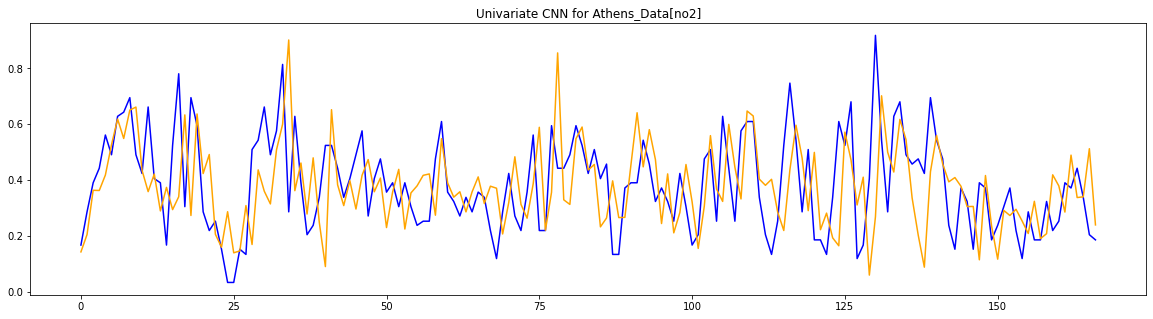

Univariate CNN MSE for Athens[o3]:0.0131895775
Univariate CNN RMSE for Athens[o3]:0.11484588585379062
Univariate CNN MAE for Athens[o3]:0.08561421
Univariate CNN MAPE for Athens[o3]:0.23273066


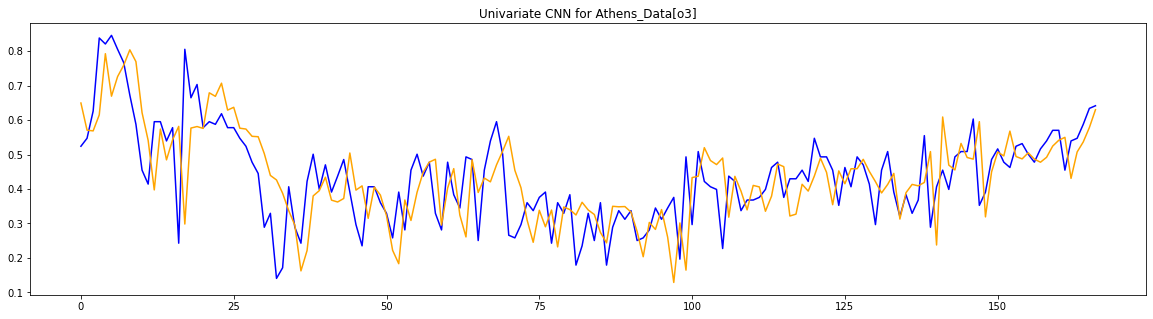

Univariate CNN MSE for Athens[pm10]:0.015651712
Univariate CNN RMSE for Athens[pm10]:0.12510680314869022
Univariate CNN MAE for Athens[pm10]:0.0927721
Univariate CNN MAPE for Athens[pm10]:0.31669912


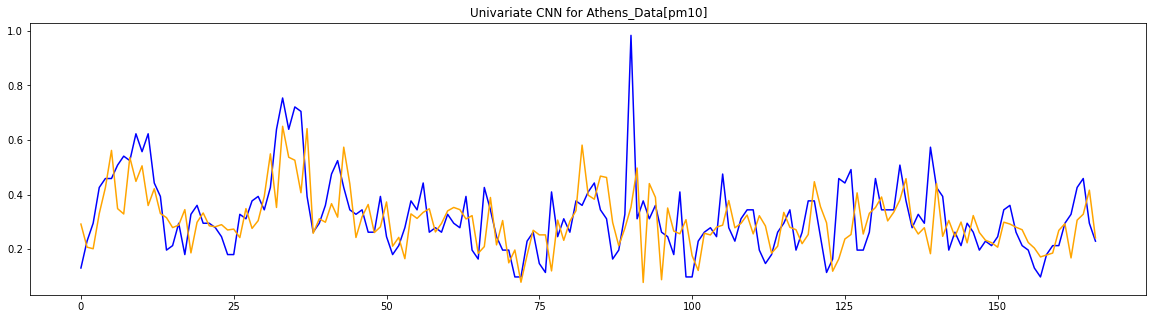

Univariate CNN MSE for Athens[pm25]:0.023772065
Univariate CNN RMSE for Athens[pm25]:0.15418192045896487
Univariate CNN MAE for Athens[pm25]:0.11553974
Univariate CNN MAPE for Athens[pm25]:0.32805964


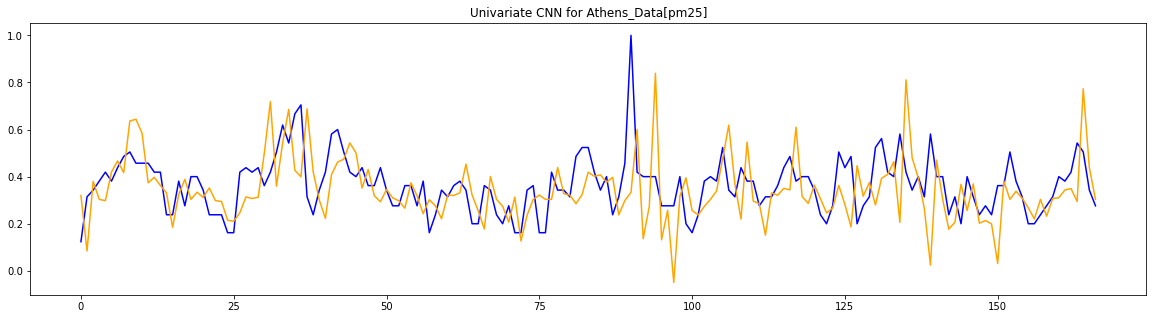

Univariate CNN MSE for Athens[so2]:0.028688034
Univariate CNN RMSE for Athens[so2]:0.16937542337280231
Univariate CNN MAE for Athens[so2]:0.103525914
Univariate CNN MAPE for Athens[so2]:4449777500000.0


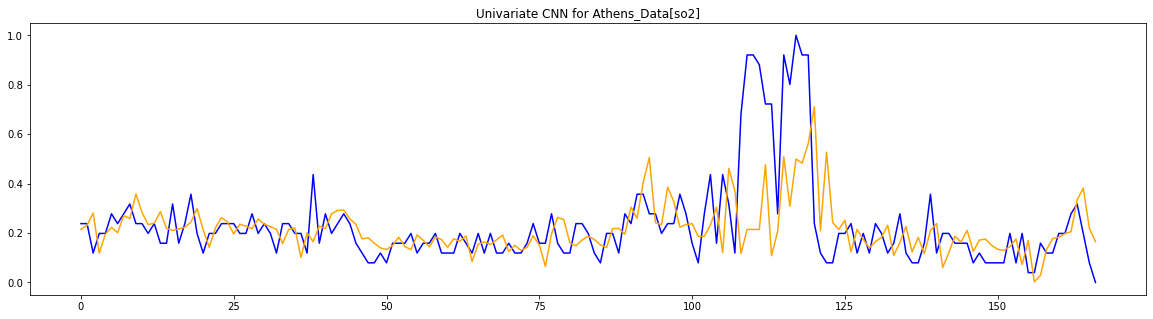

In [14]:
n_steps = 7
n_features = 1

#CNN UNIVARIATE MODEL
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=6, activation='relu', input_shape=(n_steps, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

for col in Athens_Data_uni.columns:
    
    #SPLIT DATASET AND CREATE INPUT/OUTPUT USING A WINDOW OF 'n_steps'
    window, output = split_ts_by_window(Athens_Data_uni[col], n_steps)
    
    #RESHAPE INPUT TO PASS IT TO THE MODEL
    window = window.reshape((window.shape[0], window.shape[1], n_features))
    
    #SPLIT TO TRAIN AND TEST PORTIONS
    train_size = int(len(output) * 0.8)
    train_X, test_X = window[0:train_size], window[train_size:]
    train_y, test_y = output[0:train_size], output[train_size:]
    
    #FIT TRAIN DATA TO THE MODEL
    model.fit(np.asarray(train_X), np.asarray(train_y), epochs=1000, verbose=0)
    
    #TEST THE MODEL ACCURACY
    test_X = test_X.reshape((test_X.shape[0], n_steps, n_features))
    
    #PREDICT THE TEST PORTION
    pred = model.predict(test_X, verbose=0)
    
    #CALCULATE ERROR METRICS FOR EACH TIME SERIES
    mse_ucnn = mean_squared_error(test_y, pred)
    rmse_ucnn = math.sqrt(mean_squared_error(test_y, pred))
    mae_ucnn = mean_absolute_error(test_y, pred)
    mape_ucnn = mean_absolute_percentage_error(test_y, pred)
    
    print("Univariate CNN MSE for Athens[" + str(col) + "]:" + str(mse_ucnn))
    print("Univariate CNN RMSE for Athens[" + str(col) + "]:" + str(rmse_ucnn))
    print("Univariate CNN MAE for Athens[" + str(col) + "]:" + str(mae_ucnn))
    print("Univariate CNN MAPE for Athens[" + str(col) + "]:" + str(mape_ucnn))
    
    title = "Univariate CNN for Athens_Data" + "[" + col +"]"
    
    # PLOT THE ACTUAL VS PREDICTED DATA
    plt.figure(figsize=(20, 5))
    plt.title(title)
    plt.plot(test_y, label='Actual Data', color='blue')
    plt.plot(pred, label='Predicted Data', color='orange')
    plt.show()

# MULTIVARIATE CNN

Multivariate CNN MSE for Athens[so2]:0.028688034
Multivariate CNN RMSE for Athens[so2]:0.037189049893826605
Multivariate CNN MAE for Athens[so2]:0.02996368
Multivariate CNN MAPE for Athens[so2]:0.07334855


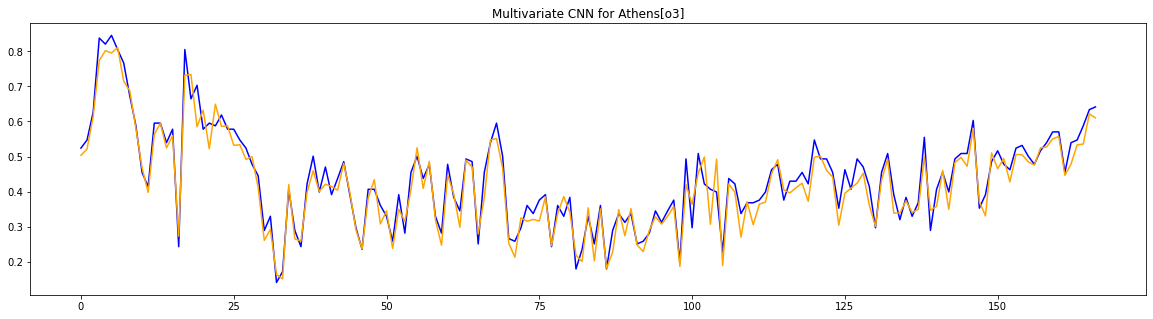

Multivariate CNN MSE for Athens[so2]:0.028688034
Multivariate CNN RMSE for Athens[so2]:0.0479456186399776
Multivariate CNN MAE for Athens[so2]:0.037485946
Multivariate CNN MAPE for Athens[so2]:0.1231501


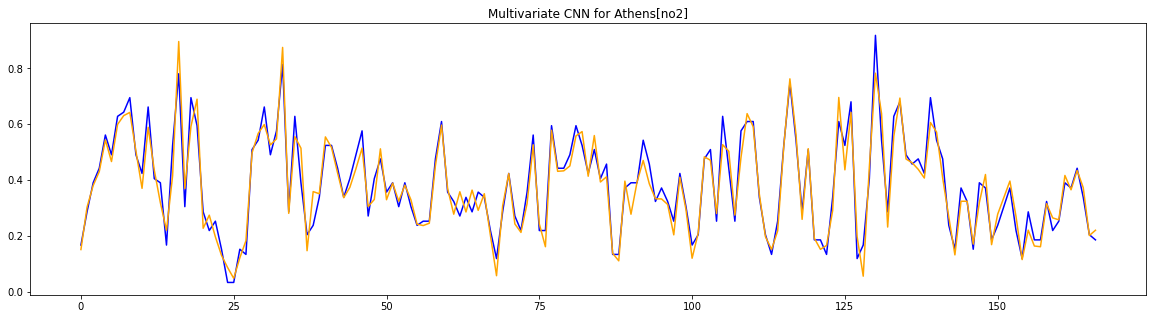

Multivariate CNN MSE for Athens[so2]:0.028688034
Multivariate CNN RMSE for Athens[so2]:0.04077864058731222
Multivariate CNN MAE for Athens[so2]:0.02786797
Multivariate CNN MAPE for Athens[so2]:63865537000.0


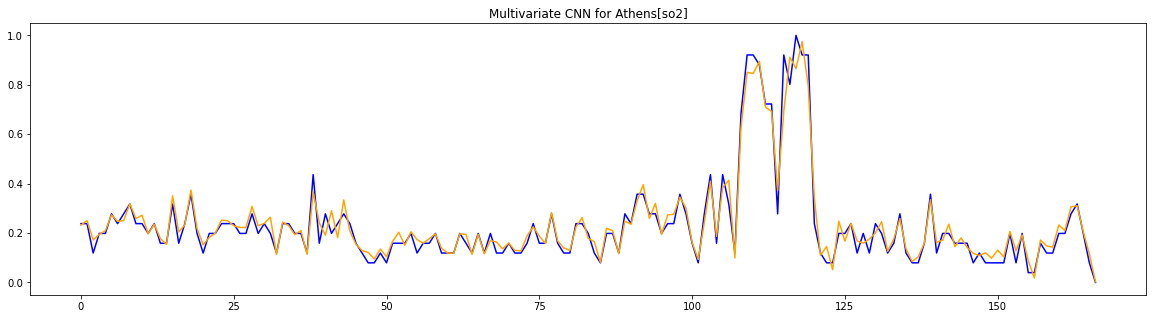

Multivariate CNN MSE for Athens[so2]:0.028688034
Multivariate CNN RMSE for Athens[so2]:0.03744982477025837
Multivariate CNN MAE for Athens[so2]:0.030281404
Multivariate CNN MAPE for Athens[so2]:0.11320553


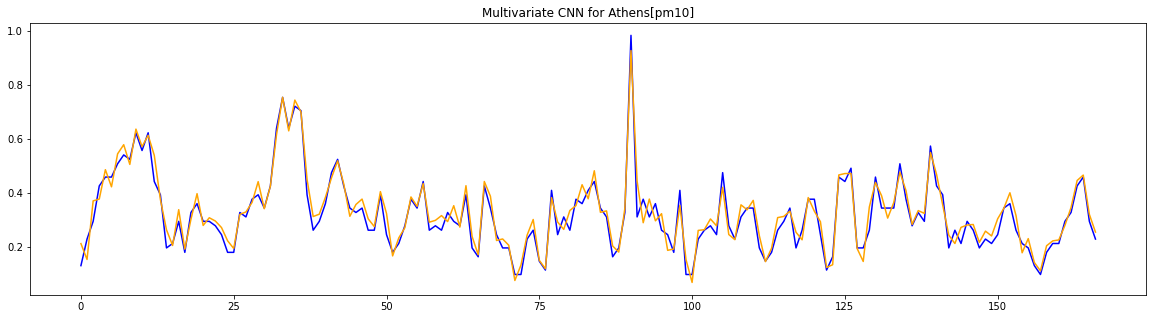

Multivariate CNN MSE for Athens[so2]:0.028688034
Multivariate CNN RMSE for Athens[so2]:0.03778629693817971
Multivariate CNN MAE for Athens[so2]:0.027321793
Multivariate CNN MAPE for Athens[so2]:0.0816952


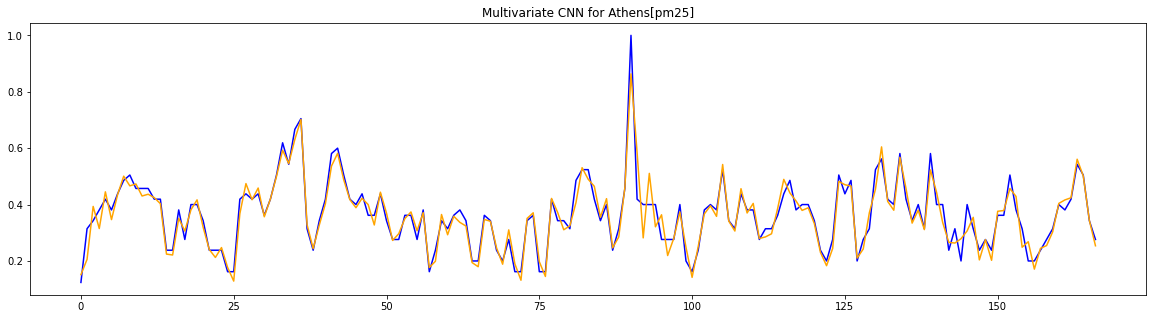

In [15]:
n_steps=7

for data in datasets:
    
    #SPLIT DATASET AND CREATE INPUT/OUTPUT USING A WINDOW OF 'n_steps'
    window, output = split_ts_by_window(np.asarray(data), n_steps)
      
    n_features= window.shape[2]
    
    #SPLIT TO TRAIN AND TEST PORTIONS
    train_size = int(len(output) * 0.8)
    train_X, test_X = window[0:train_size], window[train_size:]
    train_y, test_y = output[0:train_size], output[train_size:]
    
    #MULTIVARIATE CNN MODEL
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=6, input_shape=(n_steps, n_features)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(50))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    #FIT TRAIN DATA TO THE MODEL
    model.fit(np.asarray(train_X), np.asarray(train_y), epochs=1000, verbose=0)
    
    #TEST THE MODEL ACCURACY
    test_X = test_X.reshape((test_X.shape[0], n_steps, n_features))
    
    #PREDICT THE TEST PORTION
    pred = model.predict(test_X, verbose=0)
    
    #CALCULATE ERROR METRICS FOR EACH TIME SERIES
    rmse_ucnn = mean_squared_error(test_y, pred)
    rmse_ucnn = math.sqrt(mean_squared_error(test_y, pred))
    mae_ucnn = mean_absolute_error(test_y, pred)
    mape_ucnn = mean_absolute_percentage_error(test_y, pred)
    
    print("Multivariate CNN MSE for Athens[" + str(col) + "]:" + str(mse_ucnn))
    print("Multivariate CNN RMSE for Athens[" + str(col) + "]:" + str(rmse_ucnn))
    print("Multivariate CNN MAE for Athens[" + str(col) + "]:" + str(mae_ucnn))
    print("Multivariate CNN MAPE for Athens[" + str(col) + "]:" + str(mape_ucnn))
    
    title = "Multivariate CNN for Athens[" + str(data.columns[0]) + "]"
    
    # PLOT THE ACTUAL VS PREDICTED DATA
    plt.figure(figsize=(20, 5))
    plt.title(title)
    plt.plot(test_y, label='Actual Data', color='blue')
    plt.plot(pred, label='Predicted Data', color='orange')
    plt.show()

# UNIVARIATE LSTM

Univariate LSTM MSE for Athens[no2]:0.024787663
Univariate LSTM RMSE for Athens[no2]:0.15744098116693442
Univariate LSTM MAE for Athens[no2]:0.12645139
Univariate LSTM MAPE for Athens[no2]:0.4361299


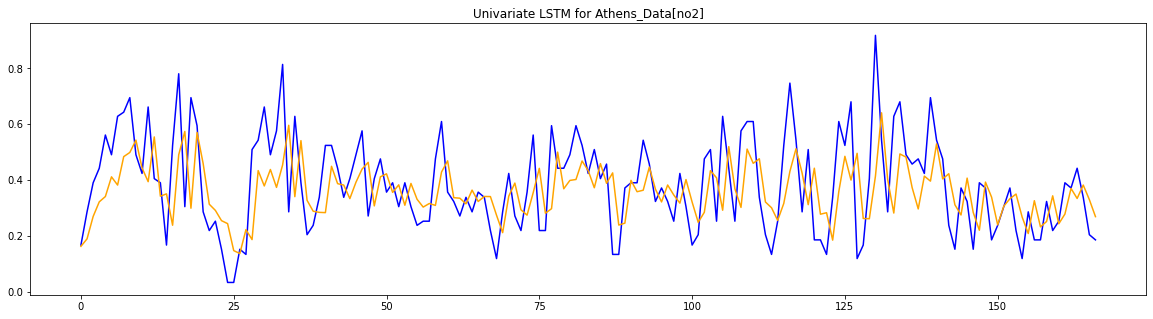

Univariate LSTM MSE for Athens[o3]:0.009120606
Univariate LSTM RMSE for Athens[o3]:0.09550186325921874
Univariate LSTM MAE for Athens[o3]:0.0720586
Univariate LSTM MAPE for Athens[o3]:0.19676903


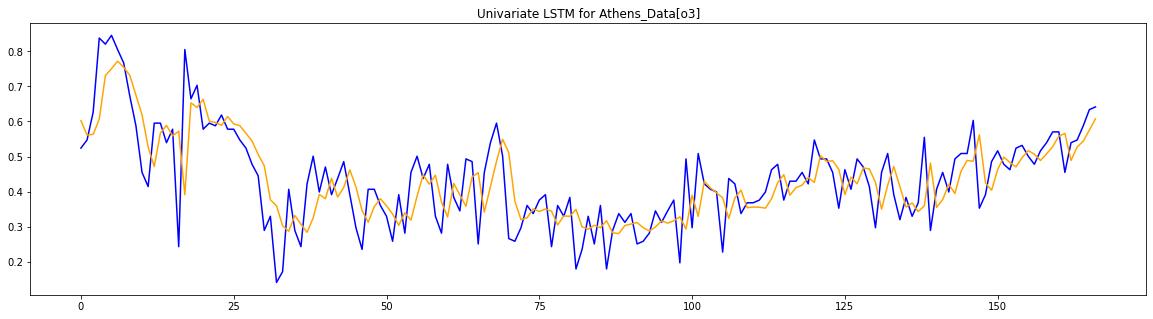

Univariate LSTM MSE for Athens[pm10]:0.013131348
Univariate LSTM RMSE for Athens[pm10]:0.11459209578417362
Univariate LSTM MAE for Athens[pm10]:0.08175352
Univariate LSTM MAPE for Athens[pm10]:0.295075


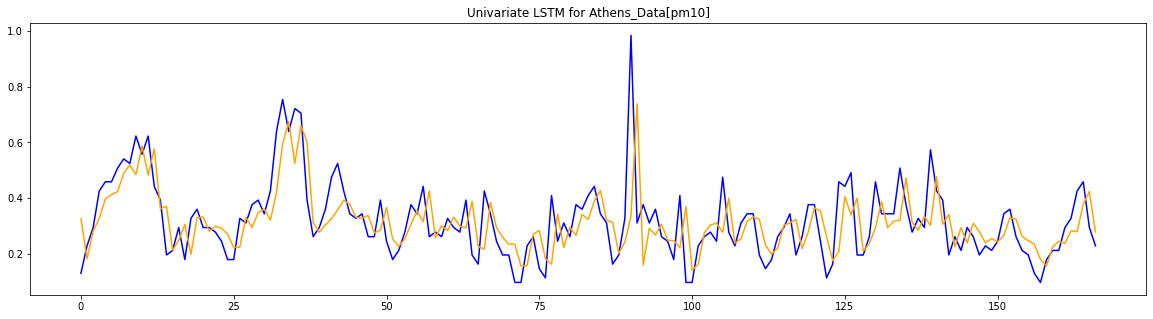

Univariate LSTM MSE for Athens[pm25]:0.0115588065
Univariate LSTM RMSE for Athens[pm25]:0.10751189015025588
Univariate LSTM MAE for Athens[pm25]:0.07826696
Univariate LSTM MAPE for Athens[pm25]:0.23868313


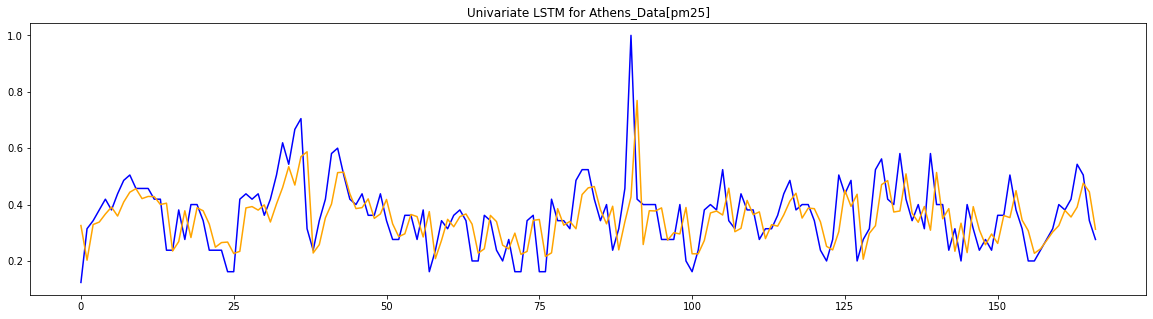

Univariate LSTM MSE for Athens[so2]:0.015712054
Univariate LSTM RMSE for Athens[so2]:0.1253477341093153
Univariate LSTM MAE for Athens[so2]:0.08358709
Univariate LSTM MAPE for Athens[so2]:4184299300000.0


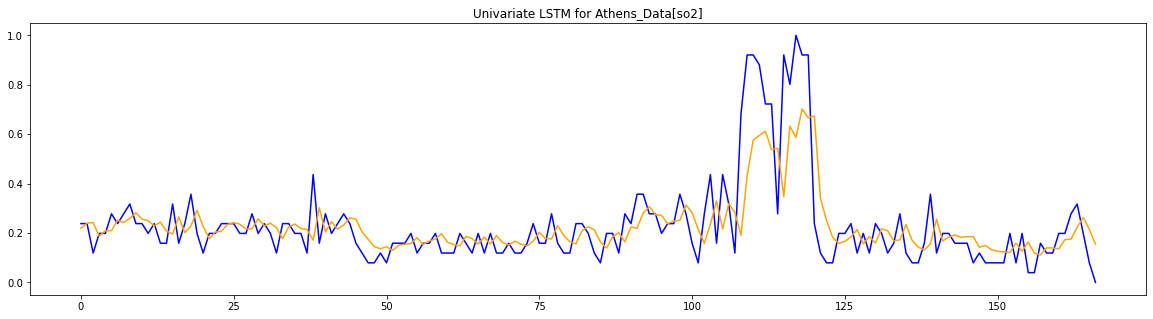

In [16]:
n_steps=7

for col in Athens_Data_uni.columns:
    window, output = split_ts_by_window(Athens_Data_uni[col], n_steps)
    
    #RESHAPE INPUT TO PASS IT TO THE MODEL
    window = window.reshape((window.shape[0], window.shape[1], 1))
    
    #UNIVARIATE LSTM MODEL
    lstm_model = Sequential()
    lstm_model.add(LSTM(50, input_shape=(n_steps, 1), activation='relu'))
    lstm_model.add(Dense(30,activation='relu'))
    lstm_model.add(Dropout(0.2))
    lstm_model.add(Dense(1,activation='relu'))
    optimizer = optimizers.RMSprop(lr=0.0001)
    lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)
    
    #SPLIT TO TRAIN AND TEST PORTIONS
    train_size = int(len(output) * 0.8)
    train_X, test_X = window[0:train_size], window[train_size:]
    train_y, test_y = output[0:train_size], output[train_size:]
    
    #FIT TRAIN DATA TO THE MODEL
    lstm_model.fit(train_X, train_y, epochs=1000, verbose=0)
    
    #TEST THE MODEL ACCURACY
    test_X = test_X.reshape((test_X.shape[0], n_steps, 1))
    
    #PREDICT THE TEST PORTION
    pred = lstm_model.predict(test_X, verbose=0)
    
    #CALCULATE ERROR METRICS FOR EACH TIME SERIES
    mse = mean_squared_error(test_y, pred)
    rmse = math.sqrt(mean_squared_error(test_y, pred))
    mae = mean_absolute_error(test_y, pred)
    mape = mean_absolute_percentage_error(test_y, pred)
    
    print("Univariate LSTM MSE for Athens[" + str(col) + "]:" + str(mse))
    print("Univariate LSTM RMSE for Athens[" + str(col) + "]:" + str(rmse))
    print("Univariate LSTM MAE for Athens[" + str(col) + "]:" + str(mae))
    print("Univariate LSTM MAPE for Athens[" + str(col) + "]:" + str(mape))
    
    title = "Univariate LSTM for Athens_Data" + "[" + col +"]"
    
    # PLOT THE ACTUAL VS PREDICTED DATA
    plt.figure(figsize=(20, 5))
    plt.title(title)
    plt.plot(test_y, label='Actual Data', color='blue')
    plt.plot(pred, label='Predicted Data', color='orange')
    plt.show()

# MULTIVARIATE LSTM

Multivariate LSTM MSE for Athens[so2]:1.230879e-05
Multivariate LSTM RMSE for Athens[so2]:0.0035083885541095363
Multivariate LSTM MAE for Athens[so2]:0.0024355631
Multivariate LSTM MAPE for Athens[so2]:0.0065369383


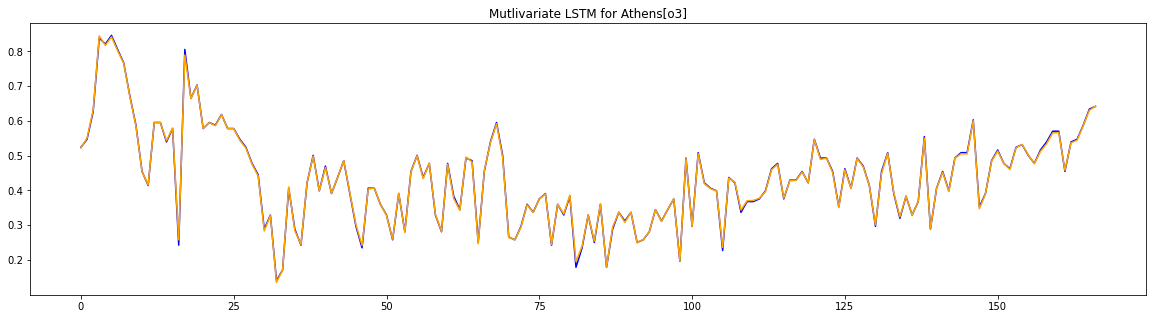

Multivariate LSTM MSE for Athens[so2]:5.3600772e-05
Multivariate LSTM RMSE for Athens[so2]:0.007321254806023715
Multivariate LSTM MAE for Athens[so2]:0.0065009324
Multivariate LSTM MAPE for Athens[so2]:0.018646095


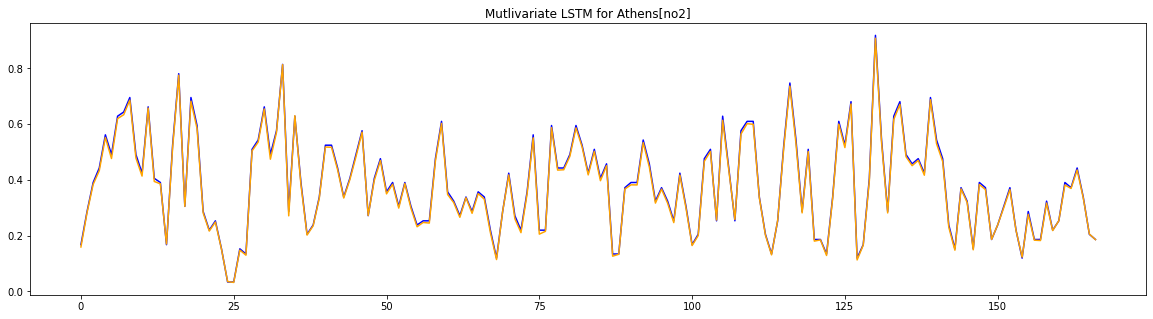

Multivariate LSTM MSE for Athens[so2]:0.00012983705
Multivariate LSTM RMSE for Athens[so2]:0.011394606092672767
Multivariate LSTM MAE for Athens[so2]:0.010428357
Multivariate LSTM MAPE for Athens[so2]:143816310000.0


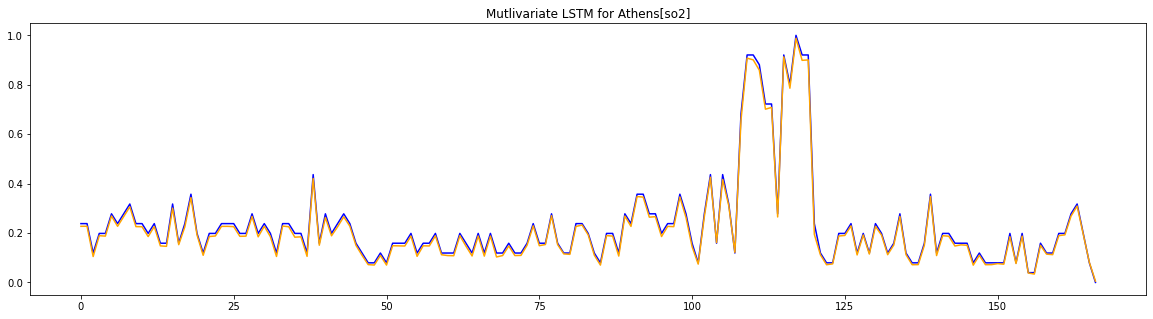

Multivariate LSTM MSE for Athens[so2]:1.2831441e-05
Multivariate LSTM RMSE for Athens[so2]:0.00358210013559397
Multivariate LSTM MAE for Athens[so2]:0.0027457317
Multivariate LSTM MAPE for Athens[so2]:0.010853301


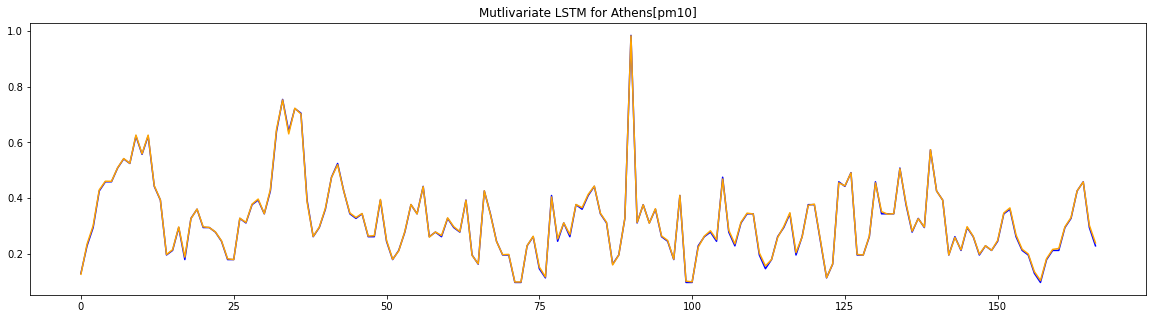

Multivariate LSTM MSE for Athens[so2]:3.8758808e-05
Multivariate LSTM RMSE for Athens[so2]:0.006225657228921834
Multivariate LSTM MAE for Athens[so2]:0.0057696686
Multivariate LSTM MAPE for Athens[so2]:0.017926821


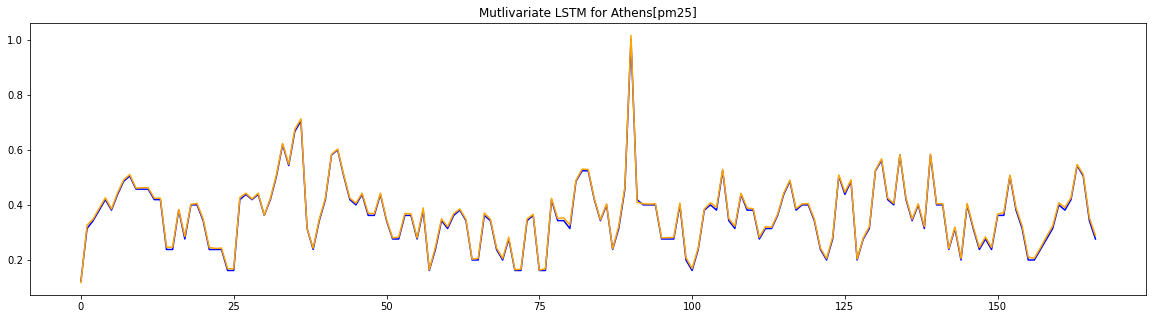

In [17]:
n_steps=7

for data in datasets:
    window, output = split_ts_by_window(np.asarray(data), n_steps)
    
    n_features = window.shape[2]
    
    #MULTIVARIATE LSTM MODEL
    lstm_model = Sequential()
    lstm_model.add(LSTM(50, input_shape=(n_steps, n_features)))
    lstm_model.add(Dense(30))
    lstm_model.add(Dropout(0.2))
    lstm_model.add(Dense(1))
    optimizer = optimizers.RMSprop(lr=0.0001)
    lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)
    
    #SPLIT TO TRAIN AND TEST PORTIONS
    train_size = int(len(output) * 0.8)
    train_X, test_X = window[0:train_size], window[train_size:]
    train_y, test_y = output[0:train_size], output[train_size:]
    
    #FIT TRAIN DATA TO THE MODEL
    lstm_model.fit(train_X, train_y, epochs=1000, verbose=0)
    
    #TEST THE MODEL ACCURACY
    test_X = test_X.reshape((test_X.shape[0], n_steps, n_features))
    
    #PREDICT THE TEST PORTION
    pred = lstm_model.predict(test_X, verbose=0)
    
    #CALCULATE ERROR METRICS FOR EACH TIME SERIES
    mse = mean_squared_error(test_y, pred)
    rmse = math.sqrt(mean_squared_error(test_y, pred))
    mae = mean_absolute_error(test_y, pred)
    mape = mean_absolute_percentage_error(test_y, pred)
    
    print("Multivariate LSTM MSE for Athens[" + str(col) + "]:" + str(mse))
    print("Multivariate LSTM RMSE for Athens[" + str(col) + "]:" + str(rmse))
    print("Multivariate LSTM MAE for Athens[" + str(col) + "]:" + str(mae))
    print("Multivariate LSTM MAPE for Athens[" + str(col) + "]:" + str(mape))

    title = "Mutlivariate LSTM for Athens" + "[" + str(data.columns[0]) +"]"
    
    # PLOT THE ACTUAL VS PREDICTED DATA
    plt.figure(figsize=(20, 5))
    plt.title(title)
    plt.plot(test_y, label='Actual Data', color='blue')
    plt.plot(pred, label='Predicted Data', color='orange')
    plt.show()